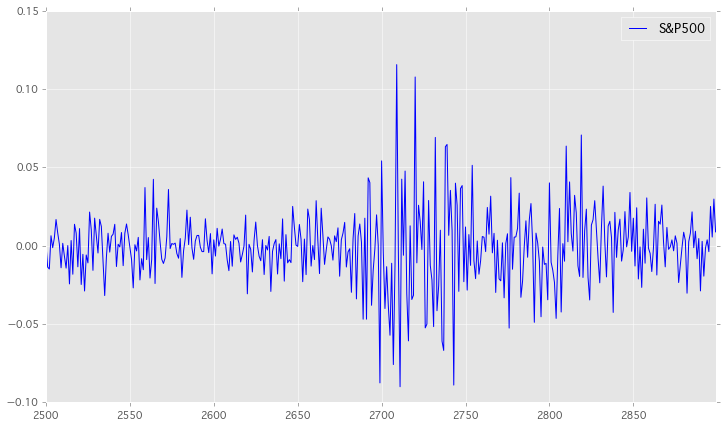

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
returns= pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/SP500.csv",
                     header=-1, parse_dates=True)[2500:2900]

plt.style.use('ggplot')
returns.columns =['S&P500']
returns.plot(figsize=(12,7), c="b")
plt.show()

In [13]:
from pymc3 import Exponential, T, exp, Deterministic, Model, sample, NUTS, find_MAP, traceplot
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = T('r', nu, lam=1/volatility_process, observed=returns['S&P500'])

In [17]:
import scipy
with sp500_model:
    start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
    step = NUTS(scaling=start)
    trace = sample(100, step, progressbar=False)

    # Start next run at the last sampled position.
    step = NUTS(scaling=trace[-1], gamma=.25)
    trace = sample(2000, step, start=trace[-1], progressbar=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120a99c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122f16f90>]], dtype=object)

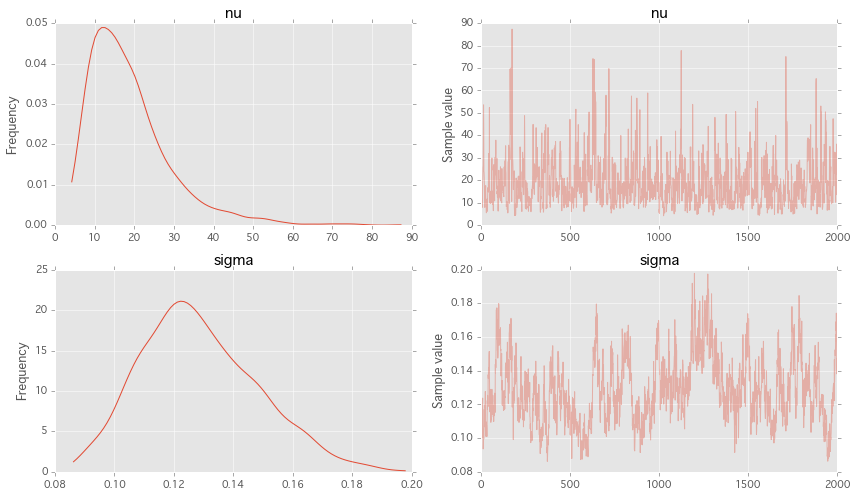

In [21]:
traceplot(trace, [nu, sigma], figsize=(12,7))

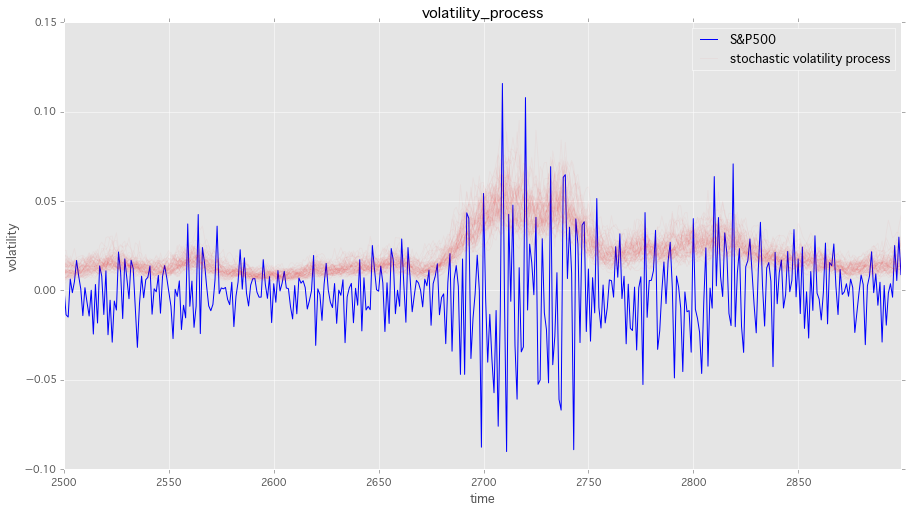

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax, color="b")
ax.plot(returns.index, 1/np.exp(trace['s',::30].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])